In [ ]:
#1.Load the dataset and handle missing values (fill with mean/median/mode)
import pandas as pd
# Load the dataset
df = pd.read_csv("HR_Data.csv")  # Change path if needed

# Handle missing values
df.fillna(df.mean(numeric_only=True), inplace=True)  # Fill numerical with mean
df.fillna(df.mode().iloc[0], inplace=True)  # Fill categorical with mode

# Display dataset info
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2002 entries, 0 to 2001
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     2002 non-null   float64
 1   last_evaluation        2002 non-null   float64
 2   number_project         2002 non-null   int64  
 3   average_montly_hours   2002 non-null   int64  
 4   time_spend_company     2002 non-null   int64  
 5   Work_accident          2002 non-null   int64  
 6   left                   2002 non-null   int64  
 7   promotion_last_5years  2002 non-null   int64  
 8   Departments            2002 non-null   object 
 9   salary                 2002 non-null   object 
dtypes: float64(2), int64(6), object(2)
memory usage: 156.5+ KB
None


In [3]:
#2. Normalize numerical features using Min-Max Scaling
from sklearn.preprocessing import MinMaxScaler

# Normalize numerical columns
scaler = MinMaxScaler()
numerical_cols = ["satisfaction_level", "last_evaluation", "number_project", "average_montly_hours", "time_spend_company"]
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Display updated dataset
print(df.head())

   satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0            0.318681         0.265625             0.0              0.285047   
1            0.692308         0.796875             0.6              0.593458   
2            0.307692         0.250000             0.0              0.294393   
3            0.351648         0.218750             0.0              0.266355   
4            0.010989         0.640625             0.8              0.705607   

   time_spend_company  Work_accident  left  promotion_last_5years Departments  \
0               0.125              0     1                      0       sales   
1               0.375              0     1                      0       sales   
2               0.125              0     1                      0       sales   
3               0.125              0     1                      0       sales   
4               0.250              0     1                      0       sales   

  salary  
0    low  
1    low  

In [4]:
#3. Encode categorical features using Label Encoding
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
categorical_cols = ["Departments", "salary"]

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders for future use

# Display encoded dataset
print(df.head())


   satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0            0.318681         0.265625             0.0              0.285047   
1            0.692308         0.796875             0.6              0.593458   
2            0.307692         0.250000             0.0              0.294393   
3            0.351648         0.218750             0.0              0.266355   
4            0.010989         0.640625             0.8              0.705607   

   time_spend_company  Work_accident  left  promotion_last_5years  \
0               0.125              0     1                      0   
1               0.375              0     1                      0   
2               0.125              0     1                      0   
3               0.125              0     1                      0   
4               0.250              0     1                      0   

   Departments  salary  
0            7       1  
1            7       1  
2            7       1  
3   

In [5]:
#4. Split the dataset into 75% training and 25% testing
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop(columns=["left"])  # Features
y = df["left"]  # Target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Training Set: {X_train.shape}, Testing Set: {X_test.shape}")


Training Set: (1501, 9), Testing Set: (501, 9)


In [6]:
#5. Design a Multi-Layer Perceptron (MLP) using torch.nn.Module
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define MLP Model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 2)  # 2 classes (left or not)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.output(x))
        return x

# Initialize model
model = MLP(input_size=X_train.shape[1])
print(model)


MLP(
  (fc1): Linear(in_features=9, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


In [7]:
#6. Train the model for 100 epochs
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 10/100, Loss: 16.2925
Epoch 20/100, Loss: 16.2582
Epoch 30/100, Loss: 16.2622
Epoch 40/100, Loss: 16.2551
Epoch 50/100, Loss: 16.2548
Epoch 60/100, Loss: 16.2579
Epoch 70/100, Loss: 16.2610
Epoch 80/100, Loss: 16.2606
Epoch 90/100, Loss: 16.2255
Epoch 100/100, Loss: 15.9278


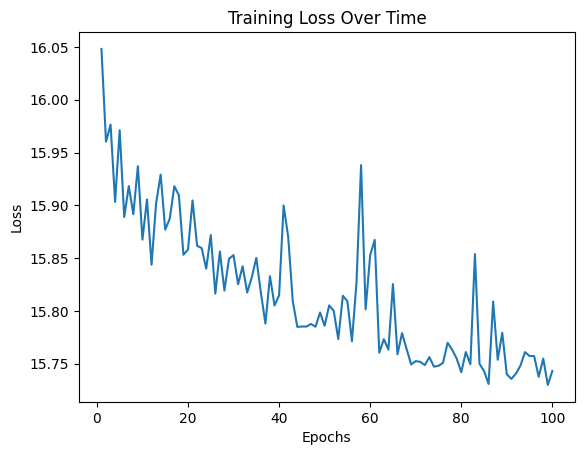

In [8]:
#7. Plot training loss vs. number of iterations
import matplotlib.pyplot as plt

loss_values = []

# Train again to record losses
for epoch in range(epochs):
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    loss_values.append(total_loss)

# Plot loss curve
plt.plot(range(1, epochs+1), loss_values)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()


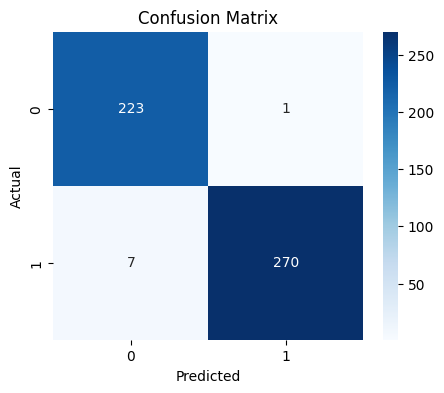

In [9]:
#8. Compute and display Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate model
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(batch_y.numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [10]:
#9. Calculate performance metrics (Accuracy, Precision, Recall, F1-score)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9840
Precision: 0.9963
Recall: 0.9747
F1 Score: 0.9854


In [11]:
#10. Interpretation of Performance Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print performance metrics
print("Model Performance Metrics Interpretation:")
print(f"Accuracy: {accuracy:.4f} - Percentage of correct predictions out of all samples.")
print(f"Precision: {precision:.4f} - When the model predicts 'left', how often is it correct?")
print(f"Recall: {recall:.4f} - Out of all employees who actually left, how many did the model identify correctly?")
print(f"F1 Score: {f1:.4f} - Balance between precision and recall (useful if classes are imbalanced).")

# Interpretation
if f1 >= 0.8:
    print("Excellent Model: Your model is performing very well with high precision and recall.")
elif f1 >= 0.6:
    print("Good Model: The model is doing well, but improvements can be made.")
else:
    print("Needs Improvement: The model may need better feature selection, tuning, or more data.")


Model Performance Metrics Interpretation:
Accuracy: 0.9840 - Percentage of correct predictions out of all samples.
Precision: 0.9963 - When the model predicts 'left', how often is it correct?
Recall: 0.9747 - Out of all employees who actually left, how many did the model identify correctly?
F1 Score: 0.9854 - Balance between precision and recall (useful if classes are imbalanced).
Excellent Model: Your model is performing very well with high precision and recall.
